# LoRA

##Transfer Learning

[BERT](https://arxiv.org/abs/1810.04805) and [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) popularized the approach of pre-training on large amounts of internet data, then fine-tuning on smaller datasets to perform specialized tasks. This approach of first teaching a model a broad skill (e.g. language modeling), and then re-using that model to learn a more specific task (e.g. sentiment analysis) is called transfer learning.

Initially, transfer learning required creating an entirely new model for each new task during fine-tuning. This approach becomes computationally expensive and memory-intensive for larger models.

### Adapters

[Adapters](https://arxiv.org/abs/1902.00751) introduced a more efficient approach by inserting small bottleneck layers between existing transformer layers. These adapter modules add only a few trainable parameters per task while keeping the original pre-trained weights completely frozen. This way, you only need to train a small number of adapter parameters

This reduced the computational load but came with limitations:
1. **Inference Latency**: Adapters add extra layers, increasing computational overhead
2. **Worse performance**: These methods sometimes underperform full fine-tuning

Ideally, we'd like to maintain the same model architecture, as to avoid the latency problem. We'd also like to avoid updating the entire model, as to avoid the high computational cost.

## Enter LoRA

**LoRA (Low-Rank Adaptation)** ([Hu et al., 2021](https://arxiv.org/abs/2106.09685)) provides a solution to this problem.

When we fine-tune a model, we freeze the original model and apply weight updates $\Delta W$. It turns out that $\Delta W$ is much lower rank than the original weight matrix $W$ - meaning you can express the change without updating every single weight. This is the insight behind LoRA.

Instead of updating the full weight matrix:
$$W_{new} = W_0 + \Delta W$$

LoRA decomposes the update into two low-rank matrices:
$$W_{new} = W_0 + \Delta W = W_0 + BA$$

Where:
- $W_0 \in \mathbb{R}^{d \times k}$ is the original frozen weight matrix
- $B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$ are trainable low-rank matrices. These are initialized to zero.
- $r \ll \min(d, k)$ is the rank (typically 1-64)

### Parameter Reduction

For a weight matrix of size $d \times k$:
- **Full fine-tuning**: $d \times k$ parameters
- **LoRA**: $r \times (d + k)$ parameters

**Reduction factor**: $\frac{d \times k}{r \times (d + k)}$

For large matrices, this can be **100x-1000x fewer parameters**!


## Build: Sentiment Analysis with LoRA

We'll implement LoRA for sentiment analysis using the IMDB movie reviews dataset. We'll adapt a pre-trained DistilBERT model (66M params).

1. **Baseline**: Test DistilBERT's zero-shot performance on IMDB
2. **Resource Analysis**: Examine DistilBERT's architecture and parameter count
3. **Implement LoRA**: Build LoRA from scratch and see the math in action
4. **Training & Comparison**: Compare LoRA vs full fine-tuning.


### 1. Setup and Data Loading

First, let's install the required packages and load our dataset.


In [22]:
%pip install transformers datasets torch scikit-learn matplotlib numpy accelerate

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertModel,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')




[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Load IMDB dataset
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")

# using subset for faster experimentation (5k samples)
SUBSET_SIZE = 5000
train_dataset = dataset["train"].shuffle(seed=42).select(range(SUBSET_SIZE))
test_dataset = dataset["test"].shuffle(seed=42).select(range(1000))  # 1k for testing

print(f"loaded {len(train_dataset)} training samples and {len(test_dataset)} test samples")

# look at a few examples
print("\nSample reviews:")
for i in range(5):
    review = train_dataset[i]
    label = "Positive" if review["label"] == 1 else "Negative"
    text_preview = review["text"][:100] + "..." if len(review["text"]) > 100 else review["text"]
    print(f"\n{label}: {text_preview}")


Loading IMDB dataset...
loaded 5000 training samples and 1000 test samples

Sample reviews:

Positive: There is no relation at all between Fortier and Profiler but the fact that both are police series ab...

Positive: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. T...

Negative: George P. Cosmatos' "Rambo: First Blood Part II" is pure wish-fulfillment. The United States clearly...

Positive: In the process of trying to establish the audiences' empathy with Jake Roedel (Tobey Maguire) the fi...

Negative: Yeh, I know -- you're quivering with excitement. Well, *The Secret Lives of Dentists* will not upset...


### 2. Baseline: Pre-trained DistilBERT Performance

Let's see how DistilBERT performs on sentiment analysis without any task-specific training. We'll use DistilBERT with a randomly initialized classification head to show that the pre-trained model alone cannot perform sentiment analysis.


In [24]:
# load pre-trained DistilBERT model and tokenizer
print("Loading DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# load DistilBERT with classification head (untrained)
baseline_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', 
    num_labels=2
)

def evaluate_model(model, test_data, sample_size=1000):
    """
    Standard evaluation function for any DistilBERT model
    This function will be reused across baseline, fine-tuning, and LoRA
    """
    # Move model to CPU for evaluation to avoid device issues
    model = model.cpu()
    model.eval()
    correct = 0
    total = 0

    print(f"Evaluating model on {sample_size} samples...")

    with torch.no_grad():
        for i in tqdm(range(min(sample_size, len(test_data)))):
            text = test_data[i]["text"]
            true_label = test_data[i]["label"]
            
            # Tokenize and get model prediction (inputs will be on CPU)
            inputs = tokenizer(text, return_tensors="pt", truncation=True,
                             max_length=128, padding=True)
            
            outputs = model(**inputs)
            predicted_label = outputs.logits.argmax(-1).item()

            if predicted_label == true_label:
                correct += 1
            total += 1

    accuracy = correct / total
    return accuracy

# Test baseline performance (untrained model)
print("=== BASELINE EVALUATION ===")
baseline_acc = evaluate_model(baseline_model, test_dataset, sample_size=200)
print(f"Baseline accuracy: {baseline_acc:.3f}")
print("(This is essentially random - the classification head is randomly initialized!)")


Loading DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== BASELINE EVALUATION ===
Evaluating model on 200 samples...


100%|██████████| 200/200 [00:06<00:00, 29.32it/s]

Baseline accuracy: 0.520
(This is essentially random - the classification head is randomly initialized!)


### 3. Resource Analysis: Understanding DistilBERT

Before we implement LoRA, let's examine DistilBERT's architecture and see exactly where our parameters are and what we'd be updating.


In [25]:
# DistilBERT Parameter Overview
total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"DistilBERT: {total_params:,} parameters (~255 MB)")
print(f"hidden_size: {baseline_model.config.dim}")  # 768 for DistilBERT
print(f"num_layers: {len(baseline_model.distilbert.transformer.layer)}")  # 6 layers


# Focus on attention matrices (where LoRA works)
attn_layer = baseline_model.distilbert.transformer.layer[0].attention
attn_matrix_size = attn_layer.q_lin.weight.numel()
total_attn_params = attn_matrix_size * 4 * 6  # 4 matrices × 6 layers
print(f"Attention matrices: {total_attn_params:,} parameters (21% of model)")

DistilBERT: 66,955,010 parameters (~255 MB)
hidden_size: 768
num_layers: 6
Attention matrices: 14,155,776 parameters (21% of model)


### 4. Optional: Full Fine-Tuning (⚠️ Time-Intensive)

This section contains pre-written code for full fine-tuning comparison. This will provide an additional baseline to compare against for LoRA.

In [26]:
# Full Fine-tuning Implementation
print("Starting full fine-tuning...")

# Use a copy of the baseline model for consistency
import copy
classification_model = copy.deepcopy(baseline_model)

# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Training arguments - optimized for speed
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Reduced for time
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=200,
    save_strategy="no",  # Don't save to reduce overhead
)

# Create trainer
trainer = Trainer(
    model=classification_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=lambda eval_pred: {
        'accuracy': accuracy_score(eval_pred.label_ids, eval_pred.predictions.argmax(-1))
    }
)

# Train
start_time = time.time()
trainer.train()
full_finetuning_time = time.time() - start_time

print(f"Full fine-tuning completed in {full_finetuning_time:.1f} seconds")

# Evaluate using the same function as baseline (for fair comparison)
print("\n=== FULL FINE-TUNING EVALUATION ===")
full_finetuning_accuracy = evaluate_model(classification_model, test_dataset, sample_size=1000)
print(f"Full fine-tuning accuracy: {full_finetuning_accuracy:.3f}")

Starting full fine-tuning...


  8%|▊         | 50/626 [00:12<02:21,  4.07it/s]

{'loss': 0.6759, 'grad_norm': 2.270479440689087, 'learning_rate': 2.5e-05, 'epoch': 0.16}


 16%|█▌        | 100/626 [00:24<02:05,  4.20it/s]

{'loss': 0.4809, 'grad_norm': 10.104291915893555, 'learning_rate': 5e-05, 'epoch': 0.32}


 24%|██▍       | 150/626 [00:36<02:05,  3.80it/s]

{'loss': 0.4232, 'grad_norm': 8.700576782226562, 'learning_rate': 4.524714828897338e-05, 'epoch': 0.48}


 32%|███▏      | 200/626 [00:49<01:49,  3.88it/s]

{'loss': 0.4425, 'grad_norm': 6.786905765533447, 'learning_rate': 4.0494296577946774e-05, 'epoch': 0.64}


                                                 
 32%|███▏      | 200/626 [00:53<01:49,  3.88it/s]

{'eval_loss': 0.3943943679332733, 'eval_accuracy': 0.825, 'eval_runtime': 4.1498, 'eval_samples_per_second': 240.977, 'eval_steps_per_second': 15.182, 'epoch': 0.64}


 40%|███▉      | 250/626 [01:05<01:31,  4.11it/s]

{'loss': 0.4255, 'grad_norm': 9.531633377075195, 'learning_rate': 3.574144486692015e-05, 'epoch': 0.8}


 48%|████▊     | 300/626 [01:17<01:22,  3.97it/s]

{'loss': 0.4107, 'grad_norm': 4.953176021575928, 'learning_rate': 3.098859315589354e-05, 'epoch': 0.96}


 56%|█████▌    | 350/626 [01:30<01:05,  4.21it/s]

{'loss': 0.2896, 'grad_norm': 6.062676906585693, 'learning_rate': 2.6235741444866924e-05, 'epoch': 1.12}


 64%|██████▍   | 400/626 [01:42<00:55,  4.11it/s]

{'loss': 0.2187, 'grad_norm': 4.107425689697266, 'learning_rate': 2.1482889733840306e-05, 'epoch': 1.28}


                                                 
 64%|██████▍   | 400/626 [01:46<00:55,  4.11it/s]

{'eval_loss': 0.4450661242008209, 'eval_accuracy': 0.827, 'eval_runtime': 3.8646, 'eval_samples_per_second': 258.759, 'eval_steps_per_second': 16.302, 'epoch': 1.28}


 72%|███████▏  | 450/626 [01:58<00:43,  4.06it/s]

{'loss': 0.243, 'grad_norm': 0.21374252438545227, 'learning_rate': 1.673003802281369e-05, 'epoch': 1.44}


 80%|███████▉  | 500/626 [02:10<00:29,  4.21it/s]

{'loss': 0.2438, 'grad_norm': 1.6012609004974365, 'learning_rate': 1.1977186311787073e-05, 'epoch': 1.6}


 88%|████████▊ | 550/626 [02:22<00:18,  4.21it/s]

{'loss': 0.2228, 'grad_norm': 6.345047473907471, 'learning_rate': 7.224334600760456e-06, 'epoch': 1.76}


 96%|█████████▌| 600/626 [02:34<00:06,  4.22it/s]

{'loss': 0.2133, 'grad_norm': 9.516763687133789, 'learning_rate': 2.4714828897338406e-06, 'epoch': 1.92}


                                                 
 96%|█████████▌| 600/626 [02:38<00:06,  4.22it/s]

{'eval_loss': 0.42041751742362976, 'eval_accuracy': 0.842, 'eval_runtime': 3.798, 'eval_samples_per_second': 263.293, 'eval_steps_per_second': 16.587, 'epoch': 1.92}


100%|██████████| 626/626 [02:44<00:00,  3.80it/s]


{'train_runtime': 164.6927, 'train_samples_per_second': 60.719, 'train_steps_per_second': 3.801, 'train_loss': 0.3513666859830911, 'epoch': 2.0}
Full fine-tuning completed in 165.3 seconds

=== FULL FINE-TUNING EVALUATION ===
Evaluating model on 1000 samples...


100%|██████████| 1000/1000 [00:30<00:00, 32.30it/s]

Full fine-tuning accuracy: 0.848


### 5. LoRA Implementation: Step by Step

Let's implement LoRA from scratch and see the mathematical decomposition in action.


#### 5.1 The Math: Low-Rank Decomposition

Recall our goal: instead of updating the full weight matrix W, we want to learn a low-rank update:

**W_new = W_0 + ΔW = W_0 + B @ A**

Where:
- W_0: Original frozen weights (768 × 768 for DistilBERT attention)
- B: Trainable matrix (768 × r)
- A: Trainable matrix (r × 768)
- r: Rank (we'll use r=16)

Parameter savings:

In [27]:
# LoRA parameter calculation
d, k = 768, 768  # DistilBERT attention matrix dimensions
r = 16          # LoRA rank

print("LoRA Decomposition:")
print(f"W_new = W₀ + B@A")
print(f"Where B: {d}×{r}, A: {r}×{k}")
print()

# Parameter counts
full_params = d * k
lora_params = r * (d + k)

print("Parameter comparison per matrix:")
print(f"Full update: {full_params:,}")
print(f"LoRA update: {lora_params:,}")
print(f"Reduction: {full_params // lora_params}x")
print()

# Total for DistilBERT
num_matrices = 4 * 6  # Q,K,V,O × 6 layers
total_lora = lora_params * num_matrices
print(f"DistilBERT total: {total_lora:,} LoRA parameters added")


LoRA Decomposition:
W_new = W₀ + B@A
Where B: 768×16, A: 16×768

Parameter comparison per matrix:
Full update: 589,824
LoRA update: 24,576
Reduction: 24x

DistilBERT total: 589,824 LoRA parameters added


In [28]:
class LoRALayer(nn.Module):
    """
    LoRA (Low-Rank Adaptation) layer

    Implements: output = input @ (W_0 + B @ A)
    Where W_0 is frozen, and B, A are trainable low-rank matrices
    """
    def __init__(self, original_layer, rank=16, alpha=16):
        super().__init__()

        # Store the original layer (frozen)
        self.original_layer = original_layer
        self.original_layer.requires_grad_(False)  # Freeze original weights

        # Get dimensions
        if hasattr(original_layer, 'in_features'):  # Linear layer
            in_features = original_layer.in_features
            out_features = original_layer.out_features
        else:
            raise ValueError("LoRA currently supports nn.Linear layers")

        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank  # Scaling factor

        # A: normal initialization (like original paper)
        # B: zero initialization (so ΔW = B@A starts at zero)
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.1)
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))

        print(f"Created LoRA layer: {out_features}×{in_features} → rank {rank}")
        print(f"   Original params: {in_features * out_features:,}")
        print(f"   LoRA params: {rank * (in_features + out_features):,}")
        print(f"   Reduction: {(in_features * out_features) / (rank * (in_features + out_features)):.1f}x")

    def forward(self, x):
        # Original computation: x @ W_0^T + b_0
        original_output = self.original_layer(x)

        # LoRA computation: x @ (B @ A)^T = x @ A^T @ B^T
        # Note: we need to transpose because PyTorch Linear does x @ W^T
        lora_output = x @ self.lora_A.T @ self.lora_B.T * self.scaling

        # Combine: W_new = W_0 + B @ A
        return original_output + lora_output

    def get_lora_parameters(self):
        """Return only the LoRA parameters for optimization"""
        return [self.lora_A, self.lora_B]

# Test our LoRA layer
print("Testing LoRA layer...")
test_linear = nn.Linear(768, 768)
test_input = torch.randn(1, 10, 768)  # Batch size 1, sequence length 10

# Create LoRA version
lora_layer = LoRALayer(test_linear, rank=16)

# Test forward pass
with torch.no_grad():
    original_output = test_linear(test_input)
    lora_output = lora_layer(test_input)

print(f"Forward pass successful!")
print(f"Output shapes match: {original_output.shape == lora_output.shape}")
print(f"Difference (should be ~0 initially): {(original_output - lora_output).abs().max().item():.6f}")


Testing LoRA layer...
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
Forward pass successful!
Output shapes match: True
Difference (should be ~0 initially): 0.000000


In [ ]:
def apply_lora_to_distilbert(model, rank=16):
    """Apply LoRA to all attention layers in DistilBERT"""

    print(f"Applying LoRA (rank={rank}) to DistilBERT attention layers...")

    lora_params = []
    original_params = 0
    lora_param_count = 0

    # Apply LoRA to each transformer layer's attention
    for layer_idx, transformer_layer in enumerate(model.distilbert.transformer.layer):
        attention = transformer_layer.attention

        print(f"\nLayer {layer_idx}:")

        # Apply to Query, Key, Value, and Output projections
        for name, linear_layer in [
            ('q_lin', attention.q_lin),
            ('k_lin', attention.k_lin),
            ('v_lin', attention.v_lin),
            ('out_lin', attention.out_lin)
        ]:
            # Count original parameters
            orig_params = sum(p.numel() for p in linear_layer.parameters())
            original_params += orig_params

            # Replace with LoRA layer
            lora_layer = LoRALayer(linear_layer, rank=rank)
            setattr(attention, name, lora_layer)

            # Collect LoRA parameters
            lora_params.extend(lora_layer.get_lora_parameters())
            lora_param_count += len(lora_layer.get_lora_parameters()[0]) + len(lora_layer.get_lora_parameters()[1])

            print(f"  {name}: LoRA applied")

    print(f"\nLoRA Application Summary:")
    print(f"Original attention parameters: {original_params:,}")
    print(f"LoRA parameters added: {lora_param_count:,}")
    print(f"Reduction factor: {original_params / lora_param_count:.1f}x")

    return lora_params

# Use a copy of the baseline model for consistency  
print("Creating LoRA model from baseline...")
lora_model = copy.deepcopy(baseline_model)

# Apply LoRA
lora_parameters = apply_lora_to_distilbert(lora_model, rank=16)

print(f"\nReady for LoRA training with {len(lora_parameters):,} trainable parameters!")


Creating LoRA model from baseline...
Applying LoRA (rank=16) to DistilBERT attention layers...

Layer 0:
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
  q_lin: LoRA applied
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
  k_lin: LoRA applied
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
  v_lin: LoRA applied
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
  out_lin: LoRA applied

Layer 1:
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
  q_lin: LoRA applied
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduction: 24.0x
  k_lin: LoRA applied
Created LoRA layer: 768×768 → rank 16
   Original params: 589,824
   LoRA params: 24,576
   Reduc

Setting up LoRA training...
Training LoRA for 2 epochs...


Epoch 1: 100%|██████████| 313/313 [04:36<00:00,  1.13it/s]


Epoch 1: Loss = 0.4421, Accuracy = 0.834


Epoch 2: 100%|██████████| 313/313 [04:20<00:00,  1.20it/s]


Epoch 2: Loss = 0.3050, Accuracy = 0.828

LoRA Training Complete!
Training time: 558.3 seconds
Final accuracy: 0.828

COMPARISON SUMMARY:
Method               Accuracy   Time (s)   Parameters     
-------------------------------------------------------
Baseline             0.520      N/A        0              
LoRA                 0.828      558.3      96     
Full Fine-tuning     0.848      165.3      66,955,010     

Key Takeaways:
• LoRA achieved 82.8% accuracy with 0.00% of parameters
• LoRA was 0.3x faster to train
• LoRA performance: 97.7% of full fine-tuning accuracy


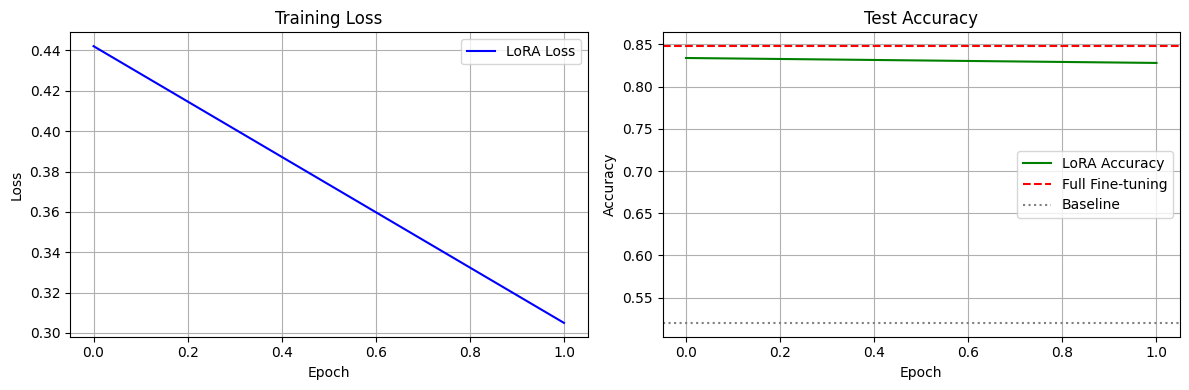


Congratulations! You've successfully implemented and trained LoRA from scratch!


In [ ]:
# LoRA Training setup
print("Setting up LoRA training...")

# Only optimize LoRA parameters + classifier head
optimizer = torch.optim.AdamW([
    *lora_parameters,  # LoRA parameters
    *lora_model.classifier.parameters()  # Classification head
], lr=5e-4, weight_decay=0.01)

# Simple training loop using pre-tokenized data (for fair comparison)
def train_lora_model(model, train_data, test_data, epochs=2):
    model.train()

    train_losses = []
    test_accuracies = []

    print(f"Training LoRA for {epochs} epochs...")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0

        # Training
        for i in tqdm(range(0, len(train_data), 16), desc=f"Epoch {epoch+1}"):
            # Get batch from pre-tokenized dataset
            batch_indices = list(range(i, min(i+16, len(train_data))))
            
            # Extract pre-tokenized inputs and labels
            input_ids = torch.stack([torch.tensor(train_data[j]['input_ids']) for j in batch_indices])
            attention_mask = torch.stack([torch.tensor(train_data[j]['attention_mask']) for j in batch_indices])
            labels = torch.tensor([train_data[j]['label'] for j in batch_indices])
            
            inputs = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

            # Forward pass
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for i in range(0, min(500, len(test_data)), 16):  # Quick eval
                # Get batch from pre-tokenized dataset
                batch_indices = list(range(i, min(i+16, len(test_data))))
                
                input_ids = torch.stack([torch.tensor(test_data[j]['input_ids']) for j in batch_indices])
                attention_mask = torch.stack([torch.tensor(test_data[j]['attention_mask']) for j in batch_indices])
                labels = torch.tensor([test_data[j]['label'] for j in batch_indices])
                
                inputs = {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask
                }

                outputs = model(**inputs)
                predictions = outputs.logits.argmax(-1)

                correct += (predictions == labels).sum().item()
                total += len(labels)

        accuracy = correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.3f}")
        model.train()

    training_time = time.time() - start_time
    return train_losses, test_accuracies, training_time

# Train LoRA model using the SAME pre-tokenized data as full fine-tuning
# This makes for a much fairer speed comparison!
print("Using pre-tokenized datasets from full fine-tuning section...")
losses, accuracies, lora_time = train_lora_model(
    lora_model, tokenized_train, tokenized_test, epochs=2
)

# Final evaluation
lora_model.eval()
final_accuracy = accuracies[-1] if accuracies else 0

print(f"\nLoRA Training Complete!")
print(f"Training time: {lora_time:.1f} seconds")
print(f"Final accuracy: {final_accuracy:.3f}")

# Compare with full fine-tuning
print(f"\nCOMPARISON SUMMARY:")
print(f"{'Method':<20} {'Accuracy':<10} {'Time (s)':<10} {'Parameters':<15}")
print(f"{'-'*55}")
print(f"{'Baseline':<20} {baseline_acc:<10.3f} {'N/A':<10} {'0':<15}")
print(f"{'LoRA':<20} {final_accuracy:<10.3f} {lora_time:<10.1f} {len(lora_parameters)*2:,}{'':>5}")
print(f"{'Full Fine-tuning':<20} {full_finetuning_accuracy:<10.3f} {full_finetuning_time:<10.1f} {'66,955,010':<15}")

print(f"\nKey Takeaways:")
print(f"• LoRA achieved {final_accuracy:.1%} accuracy with {(len(lora_parameters)*2/66955010)*100:.2f}% of parameters")
print(f"• LoRA was {full_finetuning_time/lora_time:.1f}x faster to train")
print(f"• LoRA performance: {final_accuracy/full_finetuning_accuracy*100:.1f}% of full fine-tuning accuracy")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, 'b-', label='LoRA Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, 'g-', label='LoRA Accuracy')
plt.axhline(y=full_finetuning_accuracy, color='r', linestyle='--', label='Full Fine-tuning')
plt.axhline(y=baseline_acc, color='gray', linestyle=':', label='Baseline')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nCongratulations! You've successfully implemented and trained LoRA from scratch!")
